In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from data_utils import *
from other_models import *

Using TensorFlow backend.


In [63]:
n_coef = 16

In [64]:
X = np.load('/Users/linggeli/cnn_graph/fmri/clas_data/X_259sub_40reg_16coef.npy')[:, :, :n_coef]
y = np.load('/Users/linggeli/cnn_graph/fmri/clas_data/y_259sub.npy')

In [65]:
print(X.shape)
print(y.shape)

(1036, 40, 16)
(1036,)


In [66]:
n_train = 700
n_val = 300

np.random.seed(0)
indices = np.random.permutation(X.shape[0])

In [67]:
X_train = X[indices[:n_train]]
X_val   = X[indices[n_train:n_train+n_val]]
X_test  = X[indices[n_train+n_val:]]

y_train = y[indices[:n_train]]
y_val   = y[indices[n_train:n_train+n_val]]
y_test  = y[indices[n_train+n_val:]]

In [68]:
from sklearn import preprocessing

In [69]:
X_vec = X.reshape((X.shape[0], X.shape[1] * X.shape[2]))
X_vec = preprocessing.scale(X_vec)
X_train_vec = X_vec[indices[:n_train]]
X_val_vec   = X_vec[indices[n_train:n_train+n_val]]
X_test_vec  = X_vec[indices[n_train+n_val:]]

In [77]:
print(X_train_vec.shape)

(700, 640)


In [71]:
model = LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear')

In [72]:
model.fit(X_train_vec, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)

In [78]:
print(model.C_[0])

0.3593813663804626


In [79]:
y_hat = model.predict(X_val_vec)
print(np.mean(y_hat == y_val))

0.5666666666666667


In [80]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [81]:
model = Sequential()
model.add(Dense(200, input_shape=(X_train_vec.shape[1],), activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 200)               128200    
_________________________________________________________________
dense_32 (Dense)             (None, 40)                8040      
_________________________________________________________________
dense_33 (Dense)             (None, 20)                820       
_________________________________________________________________
dropout_15 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 21        
Total params: 137,081
Trainable params: 137,081
Non-trainable params: 0
_________________________________________________________________


In [82]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [83]:
hist = model.fit(X_train_vec, y_train, batch_size=100, epochs=10, validation_data=(X_val_vec, y_val))

Train on 700 samples, validate on 300 samples
Epoch 1/10
700/700 [==============================] - 1s 1ms/step - loss: 0.7220 - acc: 0.5200 - val_loss: 0.6715 - val_acc: 0.5733
Epoch 2/10
700/700 [==============================] - 0s 87us/step - loss: 0.6029 - acc: 0.7071 - val_loss: 0.6661 - val_acc: 0.5867
Epoch 3/10
700/700 [==============================] - 0s 94us/step - loss: 0.5246 - acc: 0.8029 - val_loss: 0.6615 - val_acc: 0.6067
Epoch 4/10
700/700 [==============================] - 0s 127us/step - loss: 0.4434 - acc: 0.8543 - val_loss: 0.6775 - val_acc: 0.6033
Epoch 5/10
700/700 [==============================] - 0s 86us/step - loss: 0.3622 - acc: 0.8657 - val_loss: 0.6923 - val_acc: 0.6133
Epoch 6/10
700/700 [==============================] - 0s 104us/step - loss: 0.2994 - acc: 0.8886 - val_loss: 0.7120 - val_acc: 0.5900
Epoch 7/10
700/700 [==============================] - 0s 181us/step - loss: 0.2533 - acc: 0.8914 - val_loss: 0.7738 - val_acc: 0.6033
Epoch 8/10
700/700 [=

In [84]:
y_hat = model.predict(X_val_vec)[:, 0]
print(y_hat.shape)

(300,)


In [85]:
from keras import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Flatten, AveragePooling2D

In [89]:
n_filter = 10
filter_size = 4
dense_size = 40

In [90]:
input_image = Input(shape=(40, 16, 1))
x = Conv2D(n_filter, (filter_size, filter_size), padding='same', activation='relu')(input_image)
x = AveragePooling2D((filter_size, filter_size))(x)
x = Flatten()(x)
x = Dense(dense_size, activation='relu')(x)
x = Dropout(0.1)(x)
y = Dense(1, activation='sigmoid')(x)
conv_model = Model(input_image, y)
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 40, 16, 1)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 40, 16, 10)        170       
_________________________________________________________________
average_pooling2d_22 (Averag (None, 10, 4, 10)         0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 400)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 40)                16040     
_________________________________________________________________
dropout_18 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 41        
Total para

In [91]:
conv_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [92]:
X_train = (X_train - np.mean(X)) / np.std(X)
X_val = (X_val - np.mean(X)) / np.std(X)
X_train_image = np.expand_dims(X_train, axis=-1)
X_val_image = np.expand_dims(X_val, axis=-1)

In [93]:
conv_model.fit(X_train_image, y_train, batch_size=100, epochs=10, verbose=1, validation_data=(X_val_image, y_val))

Train on 700 samples, validate on 300 samples
Epoch 1/10
700/700 [==============================] - 1s 2ms/step - loss: 0.6945 - acc: 0.5171 - val_loss: 0.6876 - val_acc: 0.5700
Epoch 2/10
700/700 [==============================] - 0s 321us/step - loss: 0.6840 - acc: 0.5543 - val_loss: 0.6902 - val_acc: 0.5067
Epoch 3/10
700/700 [==============================] - 0s 327us/step - loss: 0.6798 - acc: 0.5871 - val_loss: 0.6826 - val_acc: 0.5733
Epoch 4/10
700/700 [==============================] - 0s 329us/step - loss: 0.6753 - acc: 0.5786 - val_loss: 0.6801 - val_acc: 0.5833
Epoch 5/10
700/700 [==============================] - 0s 312us/step - loss: 0.6701 - acc: 0.5929 - val_loss: 0.6820 - val_acc: 0.5700
Epoch 6/10
700/700 [==============================] - 0s 314us/step - loss: 0.6685 - acc: 0.6000 - val_loss: 0.6798 - val_acc: 0.5667
Epoch 7/10
700/700 [==============================] - 0s 309us/step - loss: 0.6691 - acc: 0.6100 - val_loss: 0.6775 - val_acc: 0.5933
Epoch 8/10
700/700

In [94]:
from sklearn.metrics import roc_curve, auc

In [95]:
fpr, tpr, _ = roc_curve(y_val, y_hat)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.6451698985945561


Text(0,0.5,'True Positive Rate')

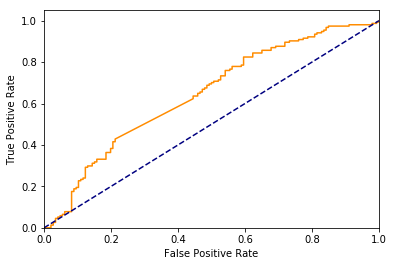

In [96]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')